# 

### Importy

In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

Using TensorFlow backend.
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as

### Wczytywanie danych

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        'test',
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

Found 27804 images belonging to 6 classes.
Found 6865 images belonging to 6 classes.


In [4]:
print(train_generator.class_indices)
print(test_generator.class_indices)
print(train_generator.image_shape)
print(test_generator.image_shape)
print(train_generator.samples)
print(test_generator.samples)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
(48, 48, 1)
(48, 48, 1)
28709
7178


### Tworzenie pierwszego modelu sieci splotowej

In [6]:
model_seq = Sequential()

model_seq.add(Conv2D(64, kernel_size=(4, 4), strides=(1, 1), \
                     activation='relu', input_shape=(48,48,1)))
model_seq.add(BatchNormalization())
model_seq.add(MaxPooling2D(pool_size=(3, 3)))
model_seq.add(Dropout(0.25))

model_seq.add(Conv2D(128, (3, 3), strides = (1, 1), activation='relu'))
model_seq.add(MaxPooling2D(pool_size=(3, 3)))
model_seq.add(Dropout(0.25))

model_seq.add(Flatten())
model_seq.add(Dense(512, activation='relu'))
model_seq.add(Dropout(0.3))
model_seq.add(Dense(7, activation='softmax'))

Pierwsza warstwa jest warstwą konwolucyjną i składa się z 64 neuronów, wielkość okna to 4x4 pixele, natomiast przemieszczenie wynosi 1. Na wyjściu tej warstwy otrzymujemy macierz 45x45x64.<br><br>

Kolejną warstwą dodaną przez nas jest BatchNormalization. Jest to warstwa normalizacji wsadowej, która zapewnia nam większą stabilność procesu uczenia oraz pozwoli na potencjalne szybsze wytrenowanie sieci (osiągnięcie takich samych rezultatów, jak przy trenowaniu bez użycia tej warstwy, lecz przy mniejszej liczbie epok). Na wyjściu tej warstwy otrzymujemy macierz o takich samych wymiarach jak macierz wejściowa (45x45x64).<br><br>

Następną warstwą jest MaxPooling2D. Jej użycie pozawala na redukcję wymiarowości, dzięki czemu tworzymy inną, bardziej ogólną oraz abstrakcyjną reprezentację danych, co z kolei może pozwolić kolejnej warstwie konwolucyjnej wykryć inne wzorce w badanych danych. Działanie tej warstwy polega na wybieraniu największej wartości spośród elementów podmacierzy 3x3, dzięki czemu w rezultacie nasza macierz wyjściowa ma rozmiar 65x15x15.<br><br>

Przed kolejną warstwa konwolucyjną, została dodana warstwa Dropout. Pozwala to zapobiec zbytniemu dopasowaniu się modelu do danych (objawiało by się to bardzo dużą skutecznością dla danych treningowych, lecz niską dla danych testowych). Szansa usunięcia neurona dla pierwszej warstwy konwolucyjnej wynosi 25\%.<br><br>

Dla zwiększenia skuteczności sieci został dodany zestaw trzech kolejnych warstw, kolejno: konwolucyjna, MaxPooling2D oraz Dropout. Zostały one stworzone w analogiczny sposób jak warstwy opisane powyżej, z różnicą jedynie w parametrach warstwy konwolucyjnej. W warstwie konwolucyjnej zmienione zostały takie parametry jak: liczba neuronów (zwiększona z 64 do 128) oraz rozmiar okna (z 4x4 na 3x3). Dodatkowa warstwa konwolucyjna oraz następujące po niej warstwy MaxPooling i Dropout pozwolą wykryć więcej szczegółów w analizowanych obrazkach oraz uzyskać jeszcze inną reprezentację danych.<br><br>

Kolejną częścią tworzonej sieci sekwencyjnej, jest sieć gęsta (w pełni połączona). Pierwszą warstwą sieci gęstej jest Flatten, który sprowadza macierz wejściową do wektora. Następną warstwą jest Dense, która to tworzy pierwszą warstwę sieci gęstej. Składa się z 512 neuronów aktywowanych funkcją relu. Dla tej warstwy został również nadany Dropout, widoczny jako kolejna warstwa. W tym miejscu szansa na usunięcie danego neurona z procesu trenowania została zwiększona do 30\%. Ostatnią warstwą naszej sieci jest Dense, której liczba neuronów wynosi 7, natomiast funkcja aktywacji ustawiona została na softmax. Funkcja softmax służy do przypisywania prawdopodobieństwa przynależności danego obrazka do każdej z dostępnych klas. Dzięki temu, wybierając największe prawdopodobieństwo, możemy stwierdzić, że dany obrazek został oznaczony określoną etykietą.<br><br>

In [8]:
model_seq.compile(loss='categorical_crossentropy',\
                  optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

model_info = model_seq.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=test_generator,
        validation_steps=7178 // 64)

Epoch 1/50
448/448 [==============================] - 300s 671ms/step - loss: 1.7529 - accuracy: 0.2893 - val_loss: 1.7337 - val_accuracy: 0.3765
Epoch 2/50
448/448 [==============================] - 268s 598ms/step - loss: 1.6046 - accuracy: 0.3776 - val_loss: 1.6173 - val_accuracy: 0.4404
Epoch 3/50
448/448 [==============================] - 266s 595ms/step - loss: 1.5101 - accuracy: 0.4205 - val_loss: 1.3044 - val_accuracy: 0.4566
Epoch 4/50
448/448 [==============================] - 262s 584ms/step - loss: 1.4486 - accuracy: 0.4451 - val_loss: 1.3127 - val_accuracy: 0.4888
Epoch 5/50
448/448 [==============================] - 262s 584ms/step - loss: 1.3967 - accuracy: 0.4691 - val_loss: 1.4642 - val_accuracy: 0.4961
Epoch 6/50
448/448 [==============================] - 275s 614ms/step - loss: 1.3588 - accuracy: 0.4819 - val_loss: 1.5248 - val_accuracy: 0.5087
Epoch 7/50
448/448 [==============================] - 331s 739ms/step - loss: 1.3232 - accuracy: 0.4975 - val_loss: 1.2582 -

### Testowanie wytrenownej sieci

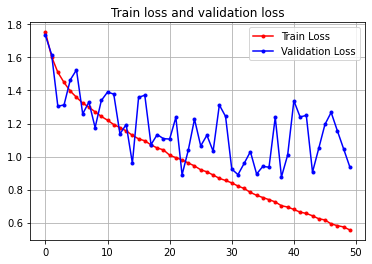

In [11]:
plt.plot(model_info.history["loss"],'r', marker='.', label="Train Loss")
plt.plot(model_info.history["val_loss"],'b', marker='.', label="Validation Loss")
plt.title("Train loss and validation loss")
plt.legend()
plt.grid()

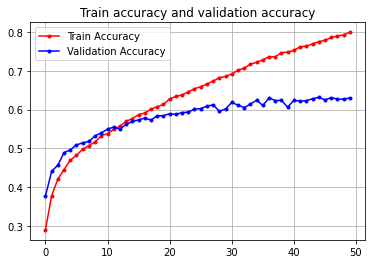

In [12]:
plt.plot(model_info.history["accuracy"],'r', marker='.', label="Train Accuracy")
plt.plot(model_info.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.title("Train accuracy and validation accuracy")
plt.legend()
plt.grid()

In [13]:
model_seq.save('v14.h5')

In [6]:
from keras.models import load_model
model_seq = load_model('v14.h5') 

In [57]:
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model_seq.predict_generator(test_generator, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

conf_matrix_neural_network = \
    confusion_matrix(y_true = test_generator.labels, y_pred = predicted_classes)

Confusion matrix, without normalization
[[127   7 110 263 163 164 124]
 [ 20   1  19  25  22  12  12]
 [134  18 106 257 186 214 109]
 [233  19 184 431 357 316 234]
 [172  12 126 315 237 208 163]
 [188  12 132 317 217 232 149]
 [117   9  87 200 152 170  96]]


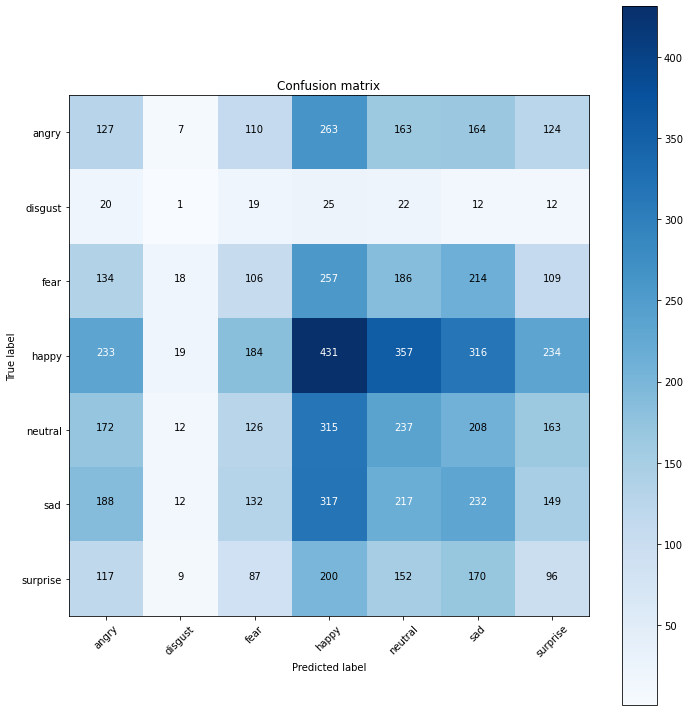

In [56]:
from plotcm import plot_confusion_matrix

plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_matrix_neural_network, test_generator.class_indices)

In [121]:
from keras.models import Model

model = Model(inputs=model_seq.inputs, outputs=model_seq.layers[1].output)

In [122]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
feature_maps = model.predict_generator(test_generator, steps=test_steps_per_epoch)

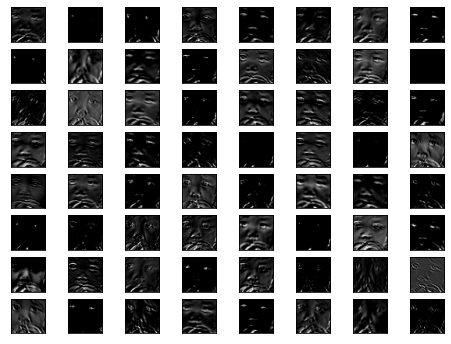

<Figure size 576x432 with 0 Axes>

In [124]:
square = 8
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[1000, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()
plt.savefig("conv1.png")

In [125]:
from keras.models import Model
model = Model(inputs=model_seq.inputs, outputs=model_seq.layers[1].output)

In [126]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
feature_maps = model.predict_generator(test_generator, steps=test_steps_per_epoch)

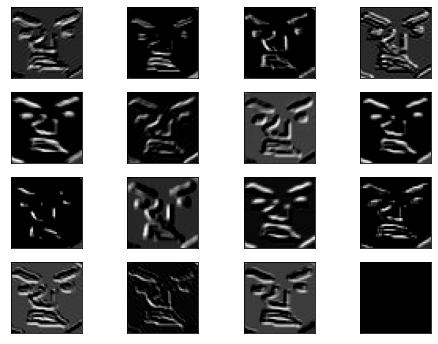

In [129]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()

### Tworzenie drugiego modelu sieci splotowej

In [4]:
model_seq = Sequential()

model_seq.add(Conv2D(64, kernel_size=(4, 4), strides=(1, 1), activation='relu', input_shape=(48,48,1)))
model_seq.add(MaxPooling2D(pool_size=(3, 3)))
model_seq.add(Dropout(0.25))

model_seq.add(Conv2D(128, (3, 3), strides = (1, 1), activation='relu'))
model_seq.add(MaxPooling2D(pool_size=(3, 3)))
model_seq.add(Dropout(0.25))

model_seq.add(Flatten())
model_seq.add(Dense(512, activation='relu'))
model_seq.add(Dropout(0.3))
model_seq.add(Dense(7, activation='softmax'))

In [5]:
model_seq.compile(loss='categorical_crossentropy',\
                  optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

model_info = model_seq.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=test_generator,
        validation_steps=7178 // 64)


Epoch 1/50
448/448 [==============================] - 52s 115ms/step - loss: 1.8108 - accuracy: 0.2525 - val_loss: 1.7815 - val_accuracy: 0.3132
Epoch 2/50
448/448 [==============================] - 46s 103ms/step - loss: 1.7220 - accuracy: 0.3054 - val_loss: 1.6549 - val_accuracy: 0.3635
Epoch 3/50
448/448 [==============================] - 47s 104ms/step - loss: 1.6273 - accuracy: 0.3658 - val_loss: 1.6359 - val_accuracy: 0.4086
Epoch 4/50
448/448 [==============================] - 45s 101ms/step - loss: 1.5531 - accuracy: 0.4025 - val_loss: 1.6512 - val_accuracy: 0.4322
Epoch 5/50
448/448 [==============================] - 46s 102ms/step - loss: 1.5075 - accuracy: 0.4256 - val_loss: 1.5262 - val_accuracy: 0.4504
Epoch 6/50
448/448 [==============================] - 47s 106ms/step - loss: 1.4702 - accuracy: 0.4387 - val_loss: 1.3364 - val_accuracy: 0.4643
Epoch 7/50
448/448 [==============================] - 47s 105ms/step - loss: 1.4390 - accuracy: 0.4544 - val_loss: 1.4577 - val_a

### Testowanie wytrenownej sieci

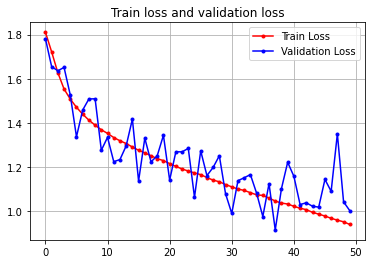

In [6]:
plt.plot(model_info.history["loss"],'r', marker='.', label="Train Loss")
plt.plot(model_info.history["val_loss"],'b', marker='.', label="Validation Loss")
plt.title("Train loss and validation loss")
plt.legend()
plt.grid()

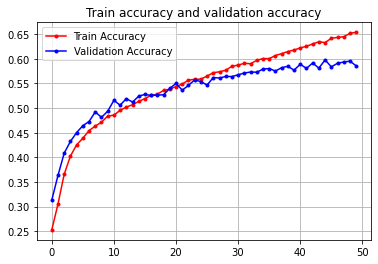

In [7]:
plt.plot(model_info.history["accuracy"],'r', marker='.', label="Train Accuracy")
plt.plot(model_info.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.title("Train accuracy and validation accuracy")
plt.legend()
plt.grid()

### Trenowanie modelu pierwszej sieci po wyczyszczeniu danych

In [ ]:
train_generator = train_datagen.flow_from_directory(
        'train_clear',
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        'test_clear',
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')

In [6]:
model_seq = Sequential()

model_seq.add(Conv2D(64, kernel_size=(4, 4), strides=(1, 1), \
                     activation='relu', input_shape=(48,48,1)))
model_seq.add(BatchNormalization())
model_seq.add(MaxPooling2D(pool_size=(3, 3)))
model_seq.add(Dropout(0.25))

model_seq.add(Conv2D(128, (3, 3), strides = (1, 1), activation='relu'))
model_seq.add(MaxPooling2D(pool_size=(3, 3)))
model_seq.add(Dropout(0.25))

model_seq.add(Flatten())
model_seq.add(Dense(512, activation='relu'))
model_seq.add(Dropout(0.3))
model_seq.add(Dense(6, activation='softmax'))

In [7]:
model_seq.compile(loss='categorical_crossentropy',\
                  optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])

model_info = model_seq.fit_generator(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=50,
        validation_data=test_generator,
        validation_steps=7178 // 64)

Epoch 1/50
448/448 [==============================] - 361s 805ms/step - loss: 1.7196 - accuracy: 0.2967 - val_loss: 1.6816 - val_accuracy: 0.4006
Epoch 2/50
448/448 [==============================] - 326s 729ms/step - loss: 1.5367 - accuracy: 0.3908 - val_loss: 1.4270 - val_accuracy: 0.4584
Epoch 3/50
448/448 [==============================] - 324s 722ms/step - loss: 1.4438 - accuracy: 0.4347 - val_loss: 1.4094 - val_accuracy: 0.4904
Epoch 4/50
448/448 [==============================] - 323s 721ms/step - loss: 1.3796 - accuracy: 0.4601 - val_loss: 1.2949 - val_accuracy: 0.4953
Epoch 5/50
448/448 [==============================] - 332s 741ms/step - loss: 1.3383 - accuracy: 0.4800 - val_loss: 1.3663 - val_accuracy: 0.5019
Epoch 6/50
448/448 [==============================] - 322s 719ms/step - loss: 1.3026 - accuracy: 0.4943 - val_loss: 1.4624 - val_accuracy: 0.5136
Epoch 7/50
448/448 [==============================] - 327s 730ms/step - loss: 1.2667 - accuracy: 0.5127 - val_loss: 1.4696 -

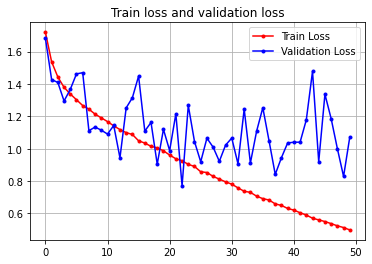

In [8]:
plt.plot(model_info.history["loss"],'r', marker='.', label="Train Loss")
plt.plot(model_info.history["val_loss"],'b', marker='.', label="Validation Loss")
plt.title("Train loss and validation loss")
plt.legend()
plt.grid()

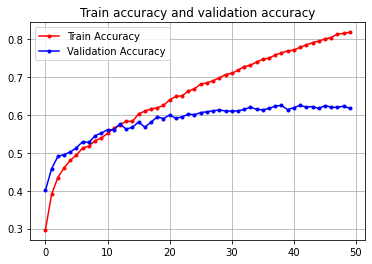

In [9]:
plt.plot(model_info.history["accuracy"],'r', marker='.', label="Train Accuracy")
plt.plot(model_info.history["val_accuracy"],'b', marker='.', label="Validation Accuracy")
plt.title("Train accuracy and validation accuracy")
plt.legend()
plt.grid()

In [10]:
model_seq.save('v15.h5')

In [11]:
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model_seq.predict_generator(test_generator, steps=test_steps_per_epoch)

predicted_classes = np.argmax(predictions, axis=1)

conf_matrix_neural_network = \
    confusion_matrix(y_true = test_generator.labels, y_pred = predicted_classes)

Confusion matrix, without normalization
[[107  91 250 231 150 126]
 [120  81 250 215 167 134]
 [185 187 453 402 316 228]
 [136 125 312 247 193 154]
 [148 138 334 238 179 139]
 [101  93 218 175 128 114]]


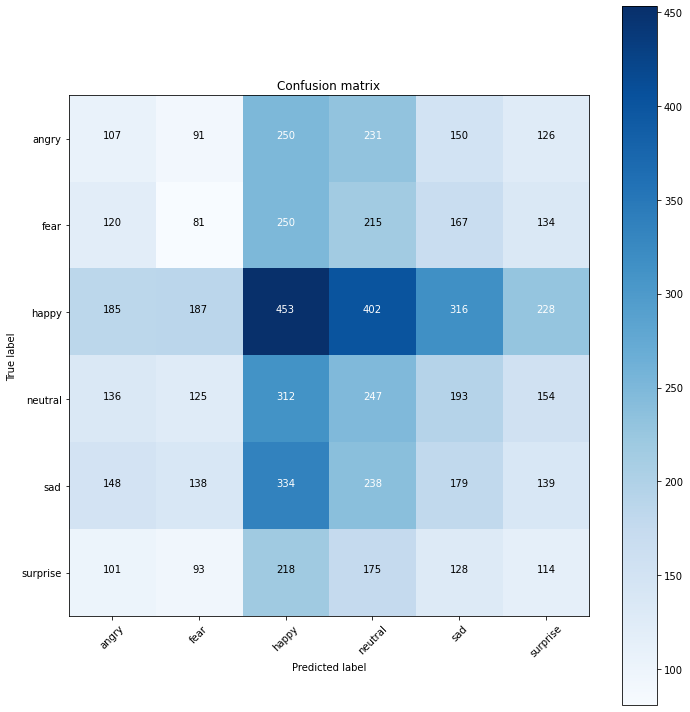

In [12]:
from plotcm import plot_confusion_matrix

plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_matrix_neural_network, test_generator.class_indices)

In [23]:
from keras.models import Model
model = Model(inputs=model_seq.inputs, outputs=model_seq.layers[1].output)

In [24]:
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
feature_maps = model.predict_generator(test_generator, steps=test_steps_per_epoch)

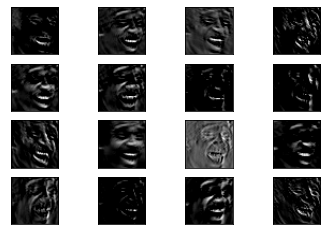

In [33]:
square = 4
ix = 1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(feature_maps[2000, :, :, ix-1], cmap='gray')
        ix += 1
plt.show()

In [32]:
test_generator.labels[2000]

2

In [4]:
from keras.models import load_model
model_seq = load_model('v15.h5')